In [1]:
import cell2cell as c2c
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mlp
from mpl_toolkits.mplot3d import Axes3D

import skbio, scipy

%matplotlib inline

# Analysis Setup

Here, all inputs and parameters needed for the analysis are defined

**Location of files**

**<font color=red>When using other organism, it is important to have the same gene IDs or names in all the data sources. *That is, rnaseq, ppi and go_annotations*.</font>**

In [2]:
files = dict()
files['rnaseq'] = '/home/hsher/c2c_input/wolock_mapped_matrix.xlsx'
files['metadata'] = '/home/hsher/c2c_input/wolock_metadata_1122.xlsx'
files['ppi'] = '/home/hsher/ppi/receptor-ligand-bader.tsv'
files['output_folder'] = '/home/hsher/c2c_output/'

**RNA-seq data manipulation**

- <font color="green">'gene_col'</font> is the name of the column containing the list or names of genes in the dataset.
- <font color="green">'drop_nangenes'</font> is a boolean decision to remove those genes with NaN values.
- <font color="green">'log_transform'</font> is a boolean decision to log-transform the dataset.

In [3]:
rnaseq_setup = dict()
rnaseq_setup['gene_col'] = None
rnaseq_setup['drop_nangenes'] = True
rnaseq_setup['log_transform'] = False

**Metadata columns**

- <font color="green">'sample_col'</font> is the name of the column containing the sample or cell names in RNA-seq data (equivalent to the columns in rnaseq_data.
- <font color="green">'group_col'</font> is the name of the column containing the labels for the respective samples or cells in order to group/color them in downstream analyses.

In [4]:
meta_setup = dict()
meta_setup['sample_col'] = 'Cell cluster'
meta_setup['group_col'] = 'FACs annotation'

**Columns for PPI network**

- <font color="green">'protein_cols'</font> is a list containing the names of the first and second interactors.

In [5]:
ppi_setup = dict()
ppi_setup['protein_cols'] = ['AliasA', 'AliasB']

**Cutoffs setup for binarizing gene expression**

- <font color="green">'type'</font> is the type of cutoff to use. So far, only 'local_percentile' and 'global_percentile' are implemented. Local percentile is used to compute the cutoff locally, gene by gene; while a global percentiles is calculated from the entire dataset.
- <font color="green">'parameter'</font> is the corresponding parameter for the type of cutoff. If percentile is used, it should be a value between 0 and 1. E.g. a value of 0.75 represents the 75-th percentile, and the cutoff to binarize the gene expression will be that value.

In [6]:
cutoff_setup = dict()
cutoff_setup['type'] = 'local_percentile'
cutoff_setup['parameter'] = 0.75

**General Analysis setups**

- <font color="green">'score_type'</font> is the type of score to calculate the interaction index for a pair of cells. It could be 'binary' to use 0 or 1 values of gene expression depending on a cutoff value for each one or 'weighted' to use a continue value between 0 and 1 given the maximal expression level of each gene.
- <font color="green">'score_metric'</font> is the metric approach to compute the score. Current options are 'bray_curtis' and 'jaccard'.

In [7]:
analysis_setup = dict()
analysis_setup['score_type'] = 'binary'
analysis_setup['score_metric'] = 'bray_curtis'

# Load Data

**RNA-seq**

In [8]:
rnaseq_data_ = c2c.io.load_rnaseq(rnaseq_file=files['rnaseq'],
                                  gene_column=rnaseq_setup['gene_col'],
                                  drop_nangenes=rnaseq_setup['drop_nangenes'],
                                  log_transformation=rnaseq_setup['log_transform'],
                                  format='auto')

Opening RNAseq datasets from /home/hsher/c2c_input/wolock_mapped_matrix.xlsx
/home/hsher/c2c_input/wolock_mapped_matrix.xlsx was correctly loaded


In [9]:
rnaseq_data_.shape

(15974, 23)

In [10]:
rnaseq_data_.index.name = 'gene_id'

In [11]:
rnaseq_data = rnaseq_data_

**Metadata for cell types**

In [12]:
meta = c2c.io.load_table(files['metadata'], format='auto')

#rnaseq_cols = list(rnaseq_data.columns)

#meta = meta.set_index('Unnamed: 0').loc[rnaseq_cols].reset_index()
#meta.index = [str(i) for i, c in enumerate(rnaseq_data.columns)]
meta.columns = ['Cell cluster', 'FACs annotation']
meta['Cell cluster'] = meta['Cell cluster'].astype(str)

/home/hsher/c2c_input/wolock_metadata_1122.xlsx was correctly loaded


In [13]:
meta

,Cell cluster,FACs annotation
0,0,Adipocyte progenitor
1,1,MSC
2,2,Early Erythro
3,3,MSC-Osteo
4,4,Pro-osteoblast
5,5,Lymphocyte
6,6,Osteoblast progenitor
7,7,Erythrocyte
8,8,Early Erythro
9,9,Pre-adipocyte


**PPI network**

In [14]:
ppi_data = c2c.io.load_ppi(ppi_file=files['ppi'],
                           interaction_columns=ppi_setup['protein_cols'],
                           rnaseq_genes=list(rnaseq_data.index),
                           format='auto')

Opening PPI datasets from /home/hsher/ppi/receptor-ligand-bader.tsv


/home/hsher/miniconda3/envs/cell2cell/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (4,5,6,7,8,9,11,12,16) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


/home/hsher/ppi/receptor-ligand-bader.tsv was correctly loaded
Removing bidirectionality of PPI network
Simplying PPI network


In [15]:
ppi_data = ppi_data.drop_duplicates().reset_index(drop=True)

# subsetting RNA-seq and meta

In [17]:
#subset_of_interest = [0,1,3,4,6,9,10,13]
#subset_of_interest = [str(s) for s in subset_of_interest]
all_proteins = set(ppi_data['A']).union(set(ppi_data['B']))
#rnaseq_data = rnaseq_data.loc[rnaseq_data.index.isin(all_proteins), subset_of_interest]
rnaseq_data = rnaseq_data.loc[rnaseq_data.index.isin(all_proteins)]
#meta = meta.loc[meta['Cell cluster'].isin(subset_of_interest)]

In [26]:
# because of duplicate index
rnaseq_data.index.unique()

Index(['C6orf120', 'C2orf69', 'C12orf49', 'C22orf46', 'C14orf93', 'ULBP3',
       'LYZ', 'A1BG', 'A2M', 'ABCA1',
       ...
       'XPNPEP2', 'XPR1', 'XYLT1', 'ZFYVE27', 'ZNRF3', 'ZP1', 'ZP3', 'ZPBP',
       'ZPBP2', 'ASIP'],
      dtype='object', name='gene_id', length=2124)

In [41]:
rnaseq_data.reset_index(inplace = True)
rnaseq_data.drop_duplicates(subset = ['gene_id'],inplace = True)
rnaseq_data.set_index('gene_id', inplace = True)
rnaseq_data.drop('index', axis = 1, inplace = True)

In [42]:
rnaseq_data.shape

(2124, 23)

# Run Analysis

**Make PPI network bidirectional for bidirectional CCI**

In [43]:
print('PPI data has {} PPIs'.format(len(ppi_data)))

PPI data has 25100 PPIs


In [44]:
bi_ppi_data = c2c.preprocessing.bidirectional_ppi_for_cci(ppi_data=ppi_data)

Making bidirectional PPI for CCI.
Removing duplicates in bidirectional PPI network.


In [45]:
print('Bidirectional PPI data has {} PPIs'.format(len(bi_ppi_data)))

Bidirectional PPI data has 49533 PPIs


**Create InteractionSpace**

In [46]:
interaction_space = c2c.core.InteractionSpace(rnaseq_data=rnaseq_data,
                                              ppi_data=bi_ppi_data,
                                              gene_cutoffs=cutoff_setup,
                                              score_type=analysis_setup['score_type'],
                                              score_metric=analysis_setup['score_metric'],
                                              verbose=False)

**Compute CCI values for each random subsampling round**

In [47]:
print('Running analysis')
interaction_space.compute_pairwise_interactions(verbose=False)

Running analysis


**Cells to exclude**

In [48]:
excluded_cells = []

In [54]:
meta

,Cell cluster,FACs annotation
0,0,Adipocyte progenitor
1,1,MSC
2,2,Early Erythro
3,3,MSC-Osteo
4,4,Pro-osteoblast
5,5,Lymphocyte
6,6,Osteoblast progenitor
7,7,Erythrocyte
8,8,Early Erythro
9,9,Pre-adipocyte


# Clustering

### Hierarchical Clustering on Average CCI matrices

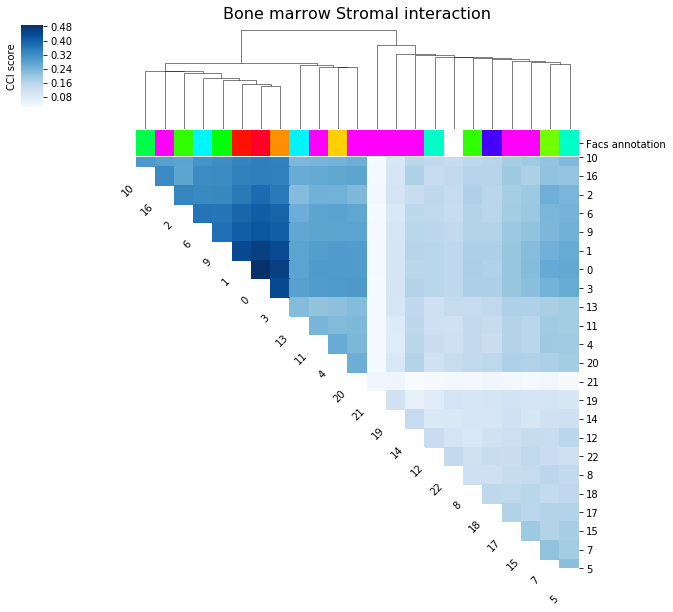

In [50]:
g = c2c.utils.clustermap_cci(interaction_space,
                         method='ward',
                         excluded_cells=excluded_cells,
                         metadata=meta,
                         sample_col=meta_setup['sample_col'],
                         group_col=meta_setup['group_col'],
                         title='Bone marrow Stromal interaction',
                         #filename=files['output_folder'] + 'CCI-Imm-Bin-Clustering-{}.png'.format(selected_patient),
                         **{'cmap' : 'Blues',
                            #'annot' : True,
                            #'figsize' : (15,15)
                           }
                         )

In [51]:
ax = g.ax_heatmap

# PCoA

TypeError: '<' not supported between instances of 'float' and 'str'

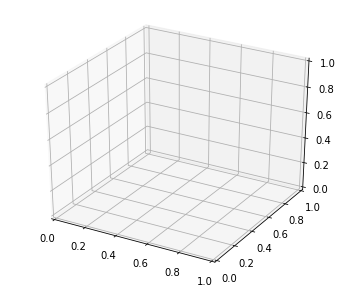

In [56]:
pcoa = c2c.utils.pcoa_biplot(interaction_space,
                             excluded_cells=excluded_cells,
                             metadata=meta,
                             sample_col=meta_setup['sample_col'],
                             group_col=meta_setup['group_col'],
                             title='Patient ',
                             #filename=files['output_folder'] + 'CCI-Imm-Bin-PCoA-{}.png'.format(selected_patient)
                             )

# Interaction Matrix

In [57]:
interaction_matrix, std_interaction_matrix = c2c.analysis.get_ppi_score_for_cell_pairs(cells=list(interaction_space.distance_matrix.columns),
                                                                                       subsampled_interactions=[interaction_space.interaction_elements],
                                                                                       ppi_data=bi_ppi_data,
                                                                                       ref_ppi_data=ppi_data
                                                                                       )

In [58]:
interaction_matrix.to_pickle('/home/hsher/c2c_output/wolock_75')